In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("ClevelandHeartDisease.txt", delim_whitespace=True, header=None)

In [3]:
print(df.head())

     0     1       2      3      4     5     6      7     8    9     10   11  \
0  63.0  male  angina  145.0  233.0  true   hyp  150.0   fal  2.3  down  0.0   
1  67.0  male  asympt  160.0  286.0   fal   hyp  108.0  true  1.5  flat  3.0   
2  67.0  male  asympt  120.0  229.0   fal   hyp  129.0  true  2.6  flat  2.0   
3  37.0  male  notang  130.0  250.0   fal  norm  187.0   fal  3.5  down  0.0   
4  41.0   fem  abnang  130.0  204.0   fal   hyp  172.0   fal  1.4    up  0.0   

     12    13  14  
0   fix  buff   H  
1  norm  sick  S2  
2   rev  sick  S1  
3  norm  buff   H  
4  norm  buff   H  


In [4]:
df = df.rename(columns={0:"age", 1:"sex", 2:"cp", 3:"trestbps", 4:"chol", 5:"fbs", 6:"restecg", 7:"thalach", 8:"exang", 
9:"oldpeak", 10:"slope", 11:"ca", 12:"thal", 14:"heartcond"})
df.drop(13, inplace=True, axis=1)

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heartcond
0,63.0,male,angina,145.0,233.0,true,hyp,150.0,fal,2.3,down,0.0,fix,H
1,67.0,male,asympt,160.0,286.0,fal,hyp,108.0,true,1.5,flat,3.0,norm,S2
2,67.0,male,asympt,120.0,229.0,fal,hyp,129.0,true,2.6,flat,2.0,rev,S1
3,37.0,male,notang,130.0,250.0,fal,norm,187.0,fal,3.5,down,0.0,norm,H
4,41.0,fem,abnang,130.0,204.0,fal,hyp,172.0,fal,1.4,up,0.0,norm,H


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        303 non-null    float64
 1   sex        303 non-null    object 
 2   cp         303 non-null    object 
 3   trestbps   303 non-null    float64
 4   chol       303 non-null    float64
 5   fbs        303 non-null    object 
 6   restecg    303 non-null    object 
 7   thalach    303 non-null    float64
 8   exang      303 non-null    object 
 9   oldpeak    303 non-null    float64
 10  slope      303 non-null    object 
 11  ca         303 non-null    object 
 12  thal       303 non-null    object 
 13  heartcond  303 non-null    object 
dtypes: float64(5), object(9)
memory usage: 33.3+ KB


In [7]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [8]:
df['thal'].unique()

array(['fix', 'norm', 'rev', '?'], dtype=object)

In [9]:
df['slope'].unique()

array(['down', 'flat', 'up'], dtype=object)

In [10]:
df['heartcond'].value_counts()

H     165
S1     54
S2     36
S3     35
S4     13
Name: heartcond, dtype: int64

In [11]:
df.dtypes

age          float64
sex           object
cp            object
trestbps     float64
chol         float64
fbs           object
restecg       object
thalach      float64
exang         object
oldpeak      float64
slope         object
ca            object
thal          object
heartcond     object
dtype: object

In [12]:
numeric_features = ['age', 'trestbps','chol','thalach', 'oldpeak']

In [13]:
# features look good!
for feature in numeric_features:
    percent_99 = np.percentile(df[feature], 99)
    percent_1 =  np.percentile(df[feature], 1)
    outliers = sum((df[feature] > percent_99) | (df[feature] < percent_1))

    print(f"{feature}:")
    print(f"  percent_1:\t{percent_1:.3f}")
    print(f"  percent_99:\t{percent_99:.3f}")
    print(f"  min: {df[feature].min():.3f}\tmax: {df[feature].max():.3f}")
    print(f"  outliers: {outliers}")
    
    # set max at 99th percentile
    # df.loc[df[feature] > percent_99, feature] = percent_99
    # set min at 1st percentile
    # df.loc[df[feature] < percent_1, feature] = percent_1

age:
  percent_1:	35.000
  percent_99:	71.000
  min: 29.000	max: 77.000
  outliers: 6
trestbps:
  percent_1:	100.000
  percent_99:	180.000
  min: 94.000	max: 200.000
  outliers: 4
chol:
  percent_1:	149.000
  percent_99:	406.740
  min: 126.000	max: 564.000
  outliers: 7
thalach:
  percent_1:	95.020
  percent_99:	191.960
  min: 71.000	max: 202.000
  outliers: 8
oldpeak:
  percent_1:	0.000
  percent_99:	4.200
  min: 0.000	max: 6.200
  outliers: 3


## Stratified k-fold

In [14]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, KBinsDiscretizer, LabelEncoder
# Column Transformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [15]:
df["kfold"] = -1

In [16]:
kf = model_selection.StratifiedKFold(n_splits=5)

In [17]:
# iterate through all the folds
# identify all the rows that will be used as validation set during each fold
for fold,(train_idx, validation_idx) in enumerate(kf.split(X=df,y=df['heartcond'])):
    print(fold, train_idx[:5], validation_idx[:5])
    df.loc[validation_idx,'kfold'] = fold

0 [42 57 61 62 63] [0 1 2 3 4]
1 [0 1 2 3 4] [42 57 61 62 63]
2 [0 1 2 3 4] [117 121 123 124 125]
3 [0 1 2 3 4] [165 172 179 180 182]
4 [0 1 2 3 4] [238 242 243 245 246]


In [18]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heartcond,kfold
0,63.0,male,angina,145.0,233.0,true,hyp,150.0,fal,2.3,down,0.0,fix,H,0
1,67.0,male,asympt,160.0,286.0,fal,hyp,108.0,true,1.5,flat,3.0,norm,S2,0
2,67.0,male,asympt,120.0,229.0,fal,hyp,129.0,true,2.6,flat,2.0,rev,S1,0
3,37.0,male,notang,130.0,250.0,fal,norm,187.0,fal,3.5,down,0.0,norm,H,0
4,41.0,fem,abnang,130.0,204.0,fal,hyp,172.0,fal,1.4,up,0.0,norm,H,0


In [19]:
df.loc[df['kfold'] == 0, 'heartcond'].value_counts()

H     33
S1    10
S2     8
S3     7
S4     3
Name: heartcond, dtype: int64

In [20]:
df.loc[df['kfold'] == 2, 'heartcond'].value_counts()

H     33
S1    11
S3     7
S2     7
S4     3
Name: heartcond, dtype: int64

In [21]:
df = df.astype({'sex':'category', 'cp':'category', 'fbs':'category', 'restecg':'category', 'exang':'category',
                'slope':'category', 'thal':'category', 'heartcond':'category'})

df['ca'] = df['ca'].astype('category', errors='ignore')

In [22]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heartcond,kfold
0,63.0,male,angina,145.0,233.0,true,hyp,150.0,fal,2.3,down,0.0,fix,H,0
1,67.0,male,asympt,160.0,286.0,fal,hyp,108.0,true,1.5,flat,3.0,norm,S2,0
2,67.0,male,asympt,120.0,229.0,fal,hyp,129.0,true,2.6,flat,2.0,rev,S1,0
3,37.0,male,notang,130.0,250.0,fal,norm,187.0,fal,3.5,down,0.0,norm,H,0
4,41.0,fem,abnang,130.0,204.0,fal,hyp,172.0,fal,1.4,up,0.0,norm,H,0


In [23]:
df.fbs.value_counts()

fal     258
true     45
Name: fbs, dtype: int64

In [24]:
# map the column to true/false
df['fbs'] = df.fbs.map({'fal':False,'true':True})

In [25]:
df['exang'] = df.exang.map({'fal':False,'true':True})

In [26]:
df.exang.value_counts()

False    204
True      99
Name: exang, dtype: int64

In [27]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'heartcond', 'kfold'],
      dtype='object')

In [28]:
df['heartcond'].value_counts()

H     165
S1     54
S2     36
S3     35
S4     13
Name: heartcond, dtype: int64

In [29]:
df['heartcond'] = df['heartcond'].map({'H':0,'S1':1,'S2':2,'S3':3,'S4':4})

In [30]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heartcond,kfold
0,63.0,male,angina,145.0,233.0,True,hyp,150.0,False,2.3,down,0.0,fix,0,0
1,67.0,male,asympt,160.0,286.0,False,hyp,108.0,True,1.5,flat,3.0,norm,2,0
2,67.0,male,asympt,120.0,229.0,False,hyp,129.0,True,2.6,flat,2.0,rev,1,0
3,37.0,male,notang,130.0,250.0,False,norm,187.0,False,3.5,down,0.0,norm,0,0
4,41.0,fem,abnang,130.0,204.0,False,hyp,172.0,False,1.4,up,0.0,norm,0,0


In [31]:
def transform_data(df, fold):    
    # merchantCategoryCode => improves score 2-3%
    # transaction type => not so much
    # posEntryMode => 2-3%

    categorical_features =['sex','cp','restecg','slope','thal']
    numeric_features = ['age', 'trestbps','chol','thalach', 'oldpeak']
    boolean_features = ['fbs','exang']
    
    # 1=True,0=False
    for col in boolean_features:
        df.loc[:,col] = df[col].astype(int)
    
    # training data - use all the data that does not belong to the fold
    # validation data - use all the data that is marked with that fold
    df_train = df.loc[df.kfold != fold].reset_index(drop=True)
    df_valid = df.loc[df.kfold == fold].reset_index(drop=True)
    
    # train
    # drop the target/label
    X_train = df_train[categorical_features+numeric_features+boolean_features]
    y_train = df_train['heartcond'].values
    
    # validation
    # drop the target/label
    X_valid = df_valid[categorical_features+numeric_features+boolean_features]
    y_valid = df_valid['heartcond'].values
    
    # learn from entire dataset for transformation - good idea or no?
    colTransformer = ColumnTransformer([
        ('onehot',OneHotEncoder(categories='auto',sparse=False),categorical_features),
        ('standardize',StandardScaler(),numeric_features)],
        remainder="passthrough")
    
    colTransformer.fit(df[categorical_features+numeric_features])   
    
    train_data_transformed = colTransformer.transform (X_train)
    valid_data_transformed = colTransformer.transform (X_valid)
        
    return (train_data_transformed, valid_data_transformed, y_train, y_valid)    

In [32]:
x_train, x_valid, y_train, y_valid = transform_data(df,1)

C:\Users\joshu\AppData\Local\Temp\ipykernel_612\1109062163.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,col] = df[col].astype(int)
C:\Users\joshu\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((242, 21), (242,), (61, 21), (61,))

In [34]:
x_train[0]

array([ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.9521966 ,  0.76395577, -0.25633371,  0.01544279,
        1.08733806])

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [36]:
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [37]:
# create predictions for validation data
preds = classifier.predict(x_valid)

In [38]:
preds

array([1, 1, 4, 0, 3, 0, 0, 1, 2, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 3, 2, 0, 0, 2, 0, 0, 0,
       0, 1, 2, 1, 2, 0, 3, 0, 0, 0, 0, 1, 3, 0, 0, 0, 2], dtype=int64)

In [39]:
# calculate and print accuracy metrics
accuracy = metrics.accuracy_score(y_valid, preds)

In [40]:
print(f'Accuracy:{accuracy:0.4f}')

Accuracy:0.6393


In [41]:
# Compute confusion matrix
labels = [0,1,2,3,4]
classes=['H','S1','S2','S3','S4']

cnf_matrix = confusion_matrix(y_valid,preds,labels=[0,1,2,3,4])

In [42]:
cnf_matrix

array([[31,  1,  0,  1,  0],
       [ 4,  2,  3,  1,  1],
       [ 1,  1,  4,  1,  0],
       [ 1,  2,  2,  2,  0],
       [ 0,  2,  1,  0,  0]], dtype=int64)

In [43]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

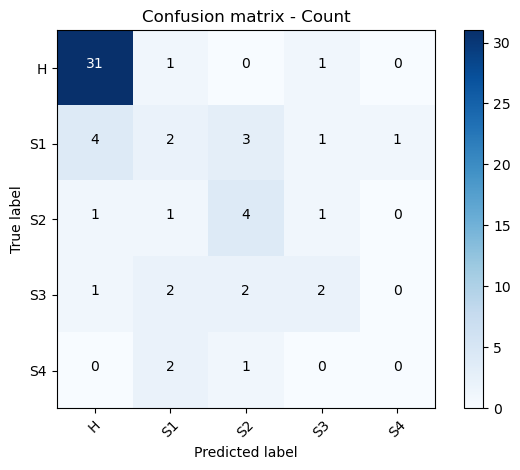

In [44]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count')

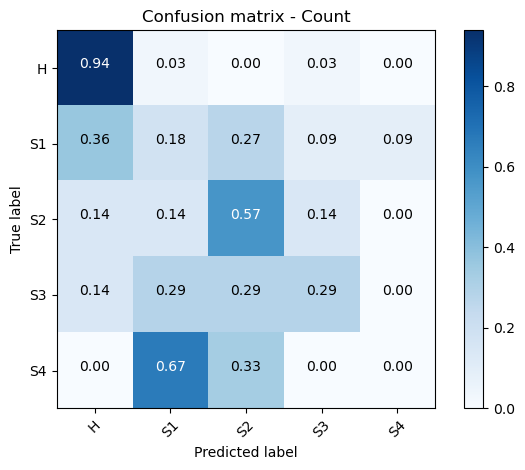

In [45]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count',normalize=True)

In [46]:
print(classification_report(y_valid,preds,labels=labels,target_names=classes))

              precision    recall  f1-score   support

           H       0.84      0.94      0.89        33
          S1       0.25      0.18      0.21        11
          S2       0.40      0.57      0.47         7
          S3       0.40      0.29      0.33         7
          S4       0.00      0.00      0.00         3

    accuracy                           0.64        61
   macro avg       0.38      0.40      0.38        61
weighted avg       0.59      0.64      0.61        61



In [47]:
import seaborn as sns

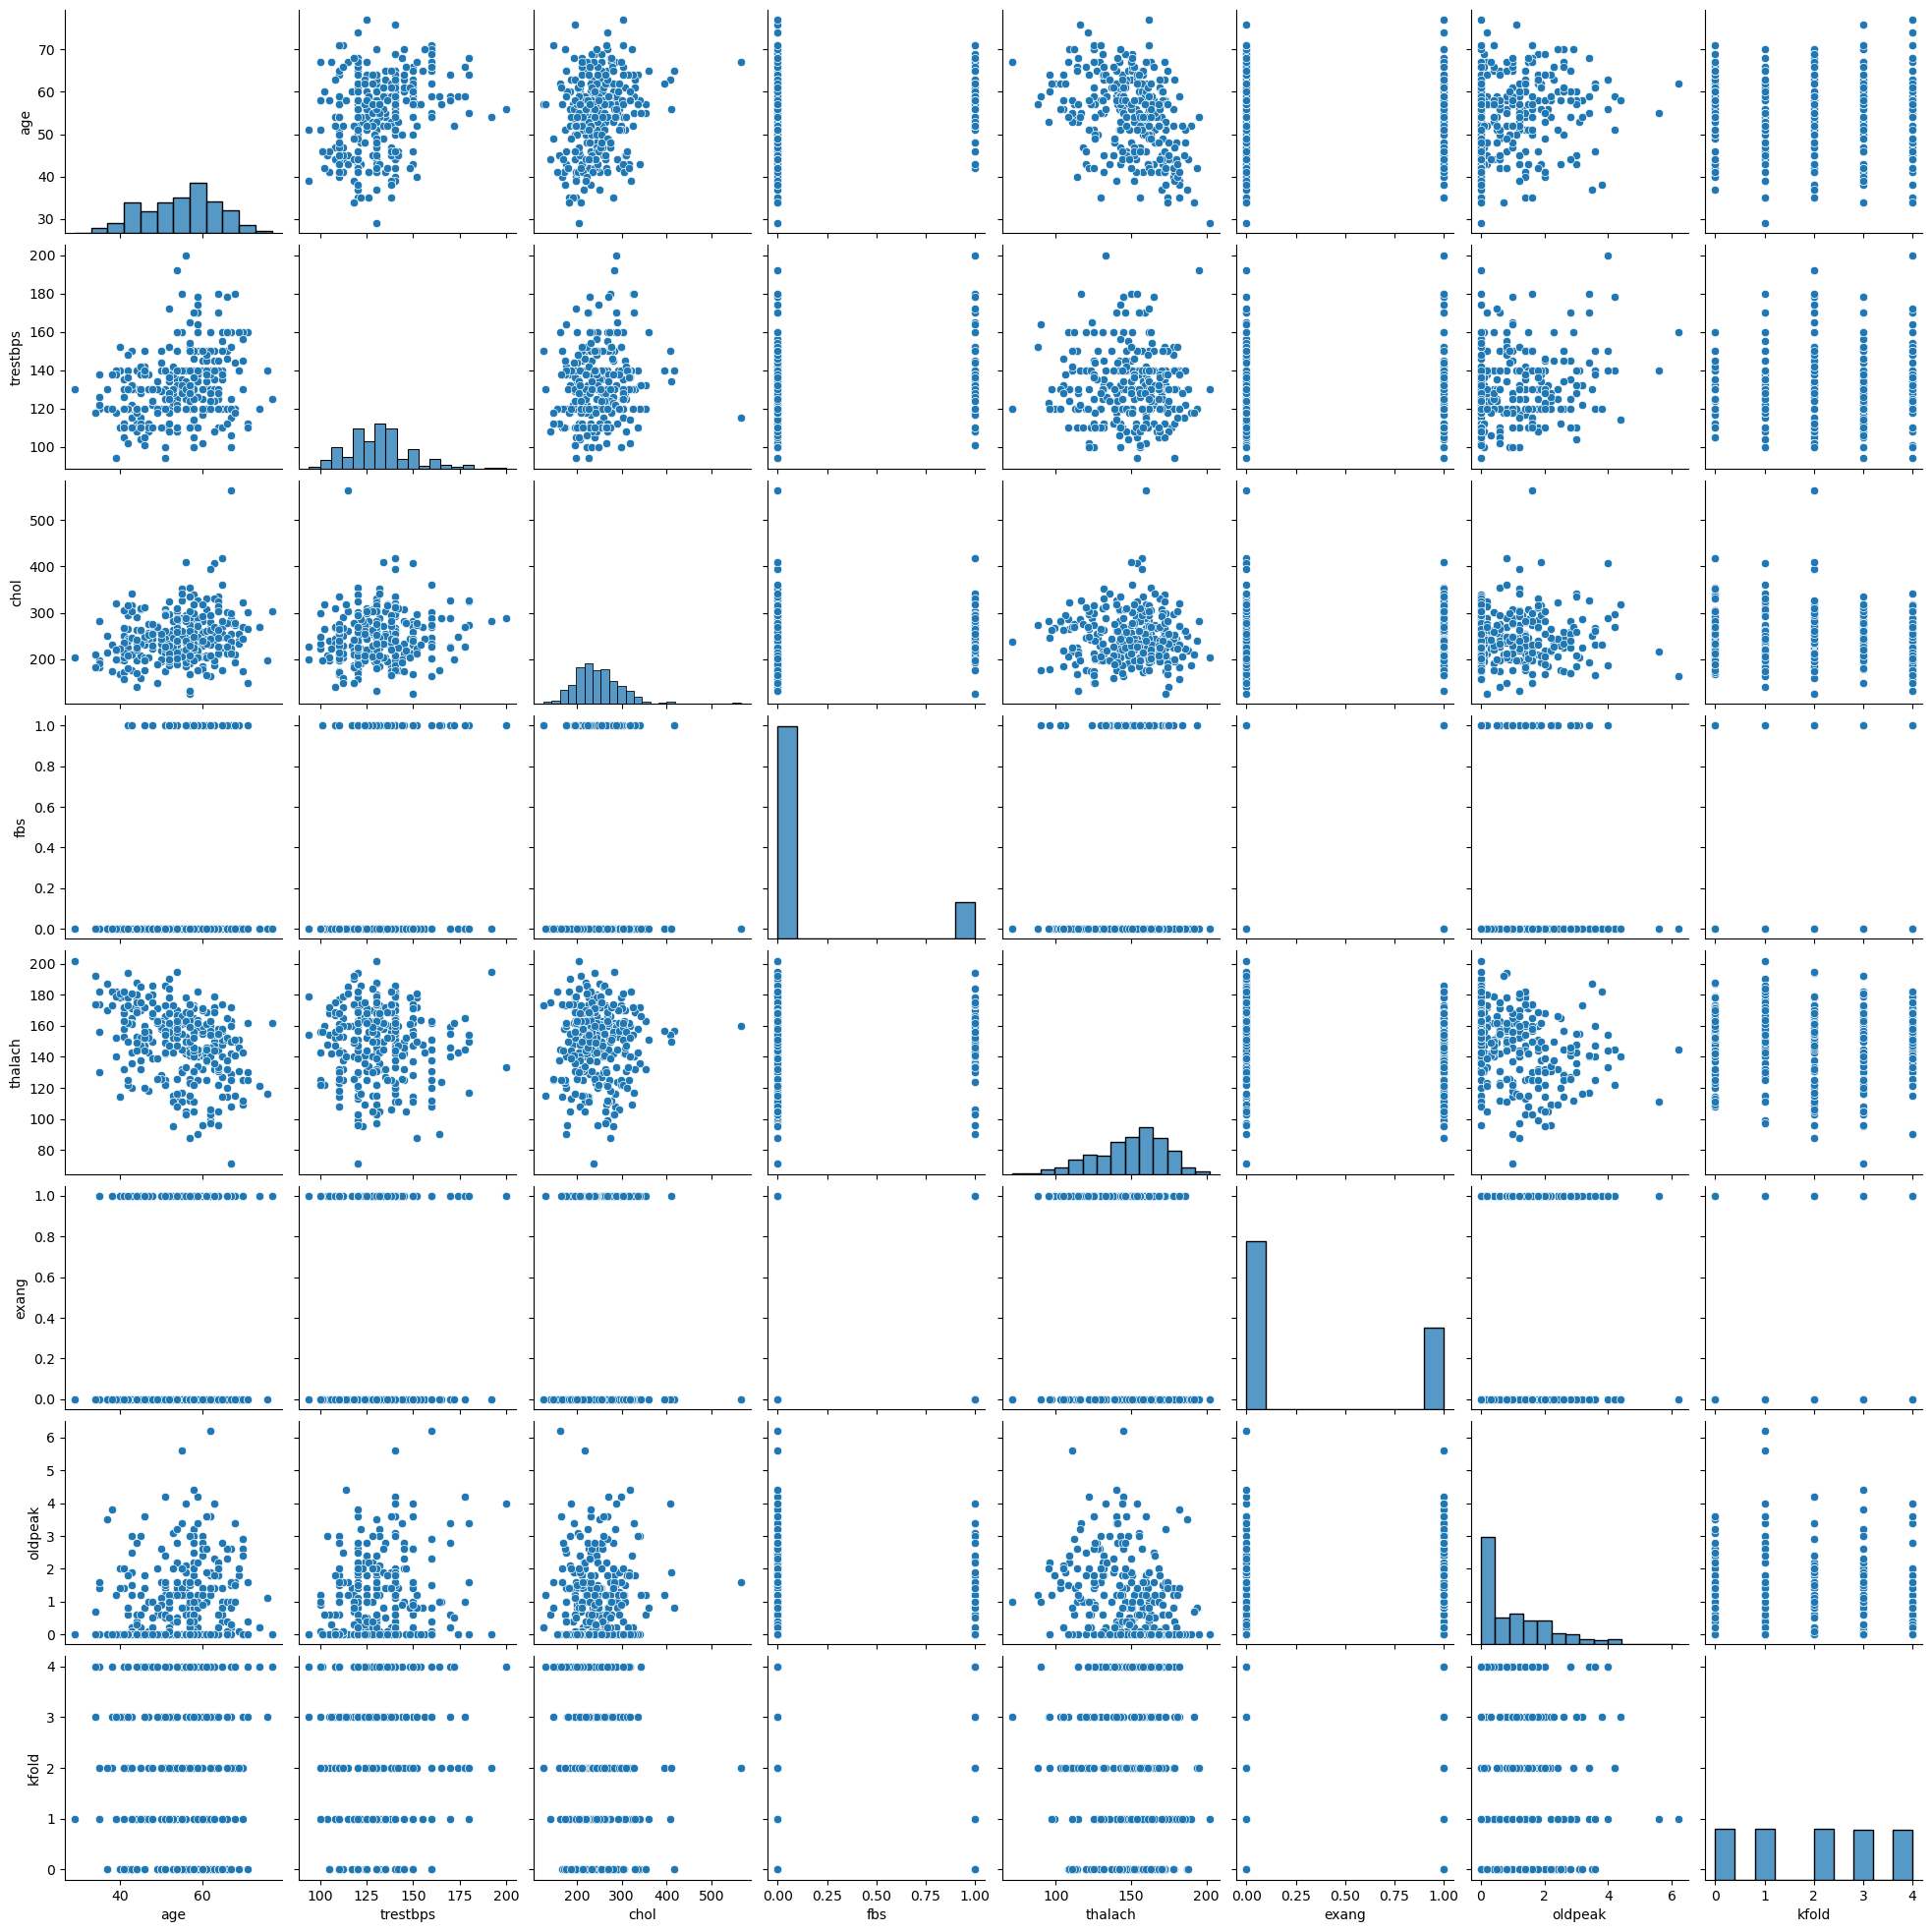

In [48]:
sns.pairplot(df)